# **DEEP LEARNING FINAL PROJECT**

## **BUILDING CONVOLUTIONAL NEURAL NETWORK ON FLOWER DATASET**
**In this Project I've built the Convolutional Neural Network which identifies the species of flower such as rose, dandelion, lily etc. This network uses ResNet50 architecture in transfer learning with best practices, using pre-trained weights from ImageNet dataset.**

### **Task 1 : Importing necessary libraries.**

---



In [ ]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


### **Task 2**: **Building useful methods.**

---








In [ ]:
"""
resnet_transfer_train.py

Transfer-learn ResNet50 (ImageNet weights) on a dataset (tf_flowers or a local/kaggle dataset).
Saves model, computes metrics (accuracy, precision, recall, f1) and plots confusion matrix.
"""

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# -----------------------
# Arguments / hyperparams
# -----------------------
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='tf_flowers', help="Use 'tf_flowers' or 'kaggle' or provide local_dir path")
parser.add_argument('--local_dir', type=str, default=None, help='If dataset == local_dir, this path should contain train/val/test subfolders')
parser.add_argument('--kaggle_dataset', type=str, default=None, help='If dataset==kaggle, the Kaggle dataset slug like "username/dataset"')
parser.add_argument('--img_size', type=int, default=224)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--learning_rate', type=float, default=1e-4)
parser.add_argument('--freeze_backbone', type=bool, default=True)
parser.add_argument('--output_dir', type=str, default='./output_model')
parser.add_argument('--seed', type=int, default=42)
# Removed the line that causes the error in Colab notebooks
# args = parser.parse_args()

# Define args directly for notebook execution
class Args:
    def __init__(self):
        self.dataset = 'tf_flowers'
        self.local_dir = None
        self.kaggle_dataset = None
        self.img_size = 224
        self.batch_size = 32
        self.epochs = 10
        self.learning_rate = 1e-4
        self.freeze_backbone = True
        self.output_dir = './output_model'
        self.seed = 42

args = Args()


# reproducibility
tf.random.set_seed(args.seed)
np.random.seed(args.seed)
os.makedirs(args.output_dir, exist_ok=True)

# -----------------------
# Helper: Optional Kaggle downloader
# -----------------------
def download_kaggle_dataset(kaggle_slug, target_dir='./kaggle_data'):
    # Requires kaggle CLI credentials in ~/.kaggle/kaggle.json or ENV
    import subprocess
    os.makedirs(target_dir, exist_ok=True)
    cmd = ['kaggle', 'datasets', 'download', '-d', kaggle_slug, '-p', target_dir, '--unzip']
    subprocess.check_call(cmd)
    return target_dir

# -----------------------
# Load dataset
# Option A: tf_flowers (automatic)
# Option B: Kaggle / local directory with ImageFolder structure
# -----------------------
def prepare_tf_flowers(img_size, batch_size, seed=42, val_split=0.2, test_split=0.1):
    (train_ds, val_ds, test_ds), info = tfds.load(
        'tf_flowers',
        split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
        as_supervised=True,
        with_info=True
    )

    num_classes = info.features['label'].num_classes # Get the number of classes

    def preprocess(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.keras.applications.resnet.preprocess_input(image)
        label = tf.one_hot(label, depth=num_classes) # One-hot encode the labels
        return image, label

    train_ds = train_ds.map(preprocess).shuffle(1024, seed=seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    class_names = info.features['label'].names
    return train_ds, val_ds, test_ds, class_names

def prepare_from_directory(local_dir, img_size, batch_size, seed=42):
    # expects local_dir contains train/, val/, test/ each having class subfolders
    train_dir = os.path.join(local_dir, 'train')
    val_dir = os.path.join(local_dir, 'val')
    test_dir = os.path.join(local_dir, 'test')

    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

    train_gen = datagen.flow_from_directory(
        train_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=True, seed=seed
    )
    val_gen = datagen.flow_from_directory(
        val_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    test_gen = datagen.flow_from_directory(
        test_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    class_names = [k for k, v in sorted(train_gen.class_indices.items(), key=lambda x: x[1])]
    return train_gen, val_gen, test_gen, class_names

# -----------------------
# Model builder
# -----------------------
def build_model(num_classes, img_size=224, lr=1e-4, freeze_backbone=True):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    if freeze_backbone:
        for layer in base.layers:
            layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy', # Revert to categorical_crossentropy
        metrics=['accuracy']
    )
    return model

# -----------------------
# Training / evaluation flow
# -----------------------
def train_and_evaluate(train_ds, val_ds, test_ds, class_names, args):
    num_classes = len(class_names)
    # Use the original build_model function
    model = build_model(num_classes, img_size=args.img_size, lr=args.learning_rate, freeze_backbone=args.freeze_backbone)
    model.summary()

    # callbacks
    ckpt_path = os.path.join(args.output_dir, 'best_model.h5')
    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
    ]

    # If generators use `.steps_per_epoch`, else tf.data handles it.
    history = model.fit(train_ds, validation_data=val_ds, epochs=args.epochs, callbacks=callbacks)

    # Load best model
    model = tf.keras.models.load_model(ckpt_path)

    # Evaluate on test set and compute metrics
    # We need predictions and true labels
    y_true = []
    y_pred = []
    y_prob = []

    # For tf.data Dataset
    if isinstance(test_ds, tf.data.Dataset):
        for batch_images, batch_labels in test_ds:
            probs = model.predict(batch_images)
            preds = np.argmax(probs, axis=1)
            # Since labels are now one-hot encoded, get the index of the true class
            trues = np.argmax(batch_labels.numpy(), axis=1)
            y_true.extend(trues.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())
    else:
        # Assuming keras generator with attributes .classes and .filenames
        probs = model.predict(test_ds, verbose=1)
        preds = np.argmax(probs, axis=1)
        y_pred = preds.tolist()
        y_prob = probs.tolist()
        # ground truth
        if hasattr(test_ds, 'classes'):
            y_true = test_ds.classes
        elif hasattr(test_ds, 'labels'):
            y_true = test_ds.labels
        else:
            # For ImageDataGenerator with class_mode='categorical', labels are one-hot.
            # Need to iterate through batches to get true labels and convert from one-hot.
            y_true_one_hot = []
            for _, batch_labels in test_ds:
                 y_true_one_hot.append(batch_labels.numpy())
            y_true_one_hot = np.concatenate(y_true_one_hot, axis=0)
            y_true = np.argmax(y_true_one_hot, axis=1).tolist()


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print('Test Accuracy:', acc)
    print('Precision (weighted):', precision)
    print('Recall (weighted):', recall)
    print('F1-score (weighted):', f1)
    print('\nClassification Report:\n', classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    cm_plot_path = os.path.join(args.output_dir, 'confusion_matrix.png')
    plt.tight_layout()
    plt.show()

    # Save final model (already saved best_model.h5). Also save entire TF SavedModel
    # Fix: Add .keras extension to the filepath for saving the SavedModel
    final_saved_path = os.path.join(args.output_dir, 'resnet_transfer_savedmodel.keras')
    model.save(final_saved_path)
    print('Saved TF SavedModel to:', final_saved_path)

    return model, history, (y_true, y_pred, y_prob), class_names # Return history and class_names

    # -----------------------
# Prediction helper: load model and predict on a few files
# -----------------------
def predict_examples(model_path, img_paths, class_names, img_size=224):
    model = tf.keras.models.load_model(model_path)
    for p in img_paths:
        img = keras_image.load_img(p, target_size=(img_size, img_size))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.resnet.preprocess_input(x)
        probs = model.predict(x)[0]
        pred_idx = np.argmax(probs)
        print(f'File: {p}')
        print(f' Predicted: {class_names[pred_idx]} (idx {pred_idx}) - confidence {probs[pred_idx]:.4f}')
        top3_idx = probs.argsort()[-3:][::-1]
        print(' Top-3:')
        for idx in top3_idx:
            print(f'   {class_names[idx]}: {probs[idx]:.4f}')
        print('---')

### **Task 3 : Load the dataset.**

---


The dataset size is 218MB, Which consists of flower photos, There are 3,670 total images.



Using method `prepare_tf_flowers` to get and store in the variables `train_ds`, `val_ds`,`test_ds`,`class_names`

In [ ]:
# Prepare the dataset using the function from resnet_transfer_train.py
# The 'args' object is already defined in the previous cell
train_ds, val_ds, test_ds, class_names = prepare_tf_flowers(
    img_size=args.img_size,
    batch_size=args.batch_size,
    seed=args.seed
)

# Train and evaluate the model using the function from resnet_transfer_train.py
# Use the original build_model function which expects categorical_crossentropy


**Dataset information**

---


Spliting the dataset into training, validation, and test sets.


In [ ]:
# Reload the dataset to get the info object
_, info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

print("Dataset Information:")
print(f"Total number of images in training dataset: {info.splits['train[:70%]'].num_examples}")
print(f"Total number of images in validation dataset: {info.splits['train[70%:85%]'].num_examples}")
print(f"Total number of images in test dataset: {info.splits['train[85%:]'].num_examples}")

# Access the target image size from the args object
# The 'args' object is defined in a previous cell
try:
    args
except NameError:
    # Define args directly for notebook execution if not already defined
    class Args:
        def __init__(self):
            self.dataset = 'tf_flowers'
            self.local_dir = None
            self.kaggle_dataset = None
            self.img_size = 224
            self.batch_size = 32
            self.epochs = 10
            self.learning_rate = 1e-4
            self.freeze_backbone = True
            self.output_dir = './output_model'
            self.seed = 42
    args = Args()


print(f"\nTarget image dimensions (height, width): ({args.img_size}, {args.img_size})")

Dataset Information:
Total number of images in training dataset: 2569
Total number of images in validation dataset: 551
Total number of images in test dataset: 550

Target image dimensions (height, width): (224, 224)


### **Task 4:** **Data Exploratory Analysis**





---


Display sample images from the dataset with their labels to visualize the data. Iterate through a batch of the training dataset and display sample images with their corresponding labels to visualize the data distribution.



---





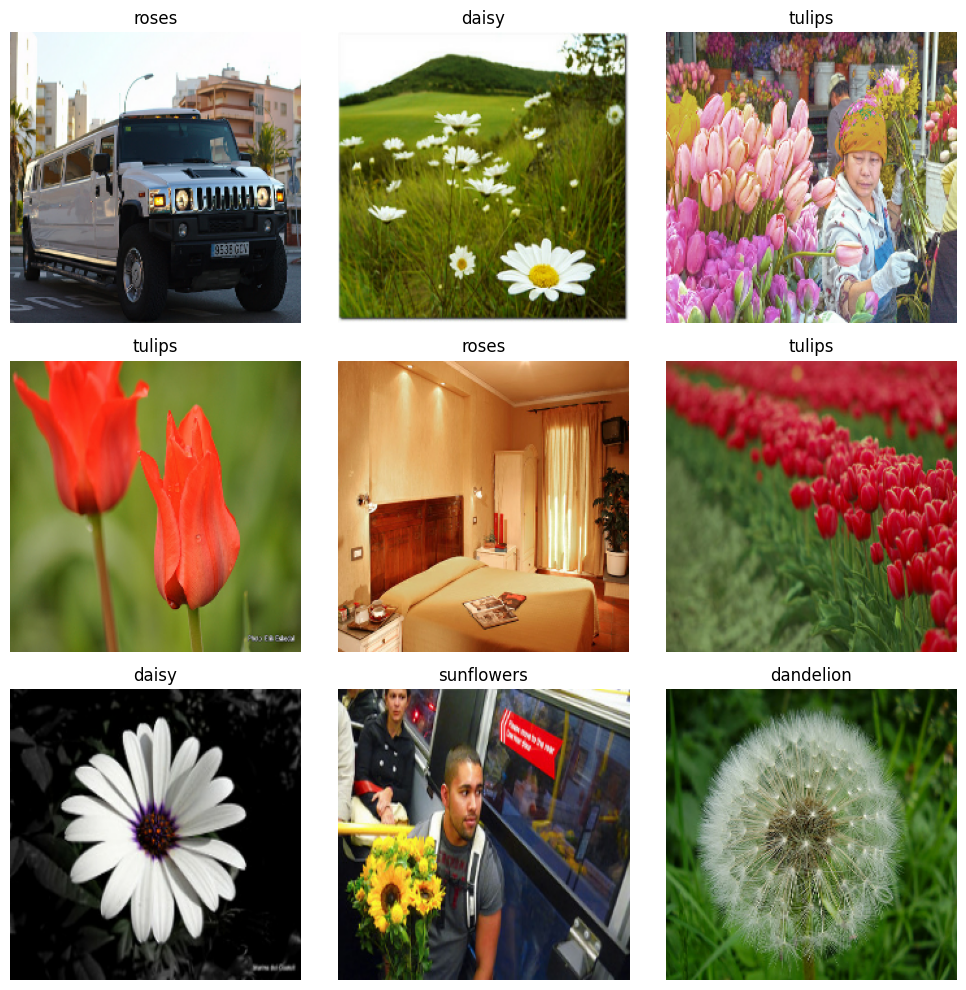

In [ ]:
# Get a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    # Display the first few images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Reverse the preprocessing for visualization
        # Add back the approximate ImageNet mean values (order is BGR for ResNet's preprocess_input output)
        img = images[i].numpy() + np.array([103.939, 116.779, 123.68])
        # Convert from BGR to RGB for display with matplotlib
        img = img[..., ::-1]
        # Clip values to the valid range [0, 255] and convert to uint8
        img = np.clip(img, 0, 255).astype('uint8')

        plt.imshow(img)
        # Get the true label index from the one-hot encoded label
        true_label_index = np.argmax(labels[i].numpy())
        # Get the class name using the index
        plt.title(class_names[true_label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

*  Count the number of images in the all different classes across the dataset.







Train Dataset Class Distribution: Counter({'dandelion': 639, 'tulips': 531, 'sunflowers': 496, 'roses': 458, 'daisy': 445})
Validation Dataset Class Distribution: Counter({'dandelion': 147, 'tulips': 134, 'sunflowers': 101, 'daisy': 93, 'roses': 76})
Test Dataset Class Distribution: Counter({'tulips': 134, 'dandelion': 112, 'roses': 107, 'sunflowers': 102, 'daisy': 95})


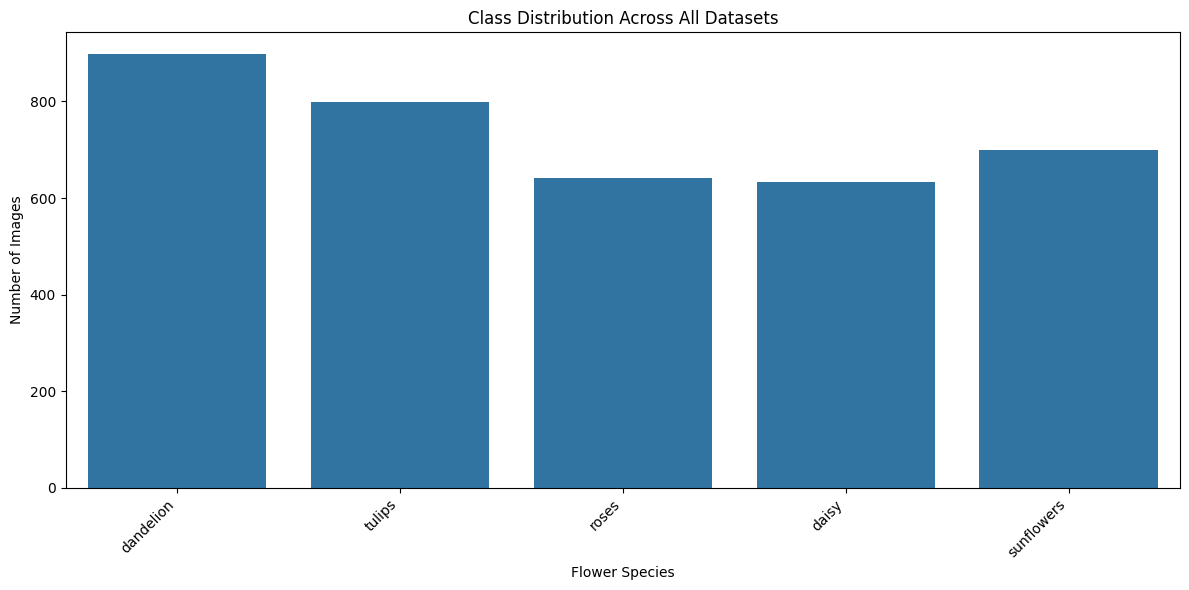

In [ ]:
import collections

def count_class_distribution(dataset, class_names):
    counts = collections.Counter()
    for _, labels in dataset:
        # Convert one-hot encoded labels back to class indices
        class_indices = tf.argmax(labels, axis=1).numpy()
        # Map class indices to class names and update counts
        for idx in class_indices:
            counts[class_names[idx]] += 1
    return counts

train_counts = count_class_distribution(train_ds, class_names)
val_counts = count_class_distribution(val_ds, class_names)
test_counts = count_class_distribution(test_ds, class_names)

print("Train Dataset Class Distribution:", train_counts)
print("Validation Dataset Class Distribution:", val_counts)
print("Test Dataset Class Distribution:", test_counts)

# Combine counts for plotting
combined_counts = collections.Counter()
combined_counts.update(train_counts)
combined_counts.update(val_counts)
combined_counts.update(test_counts)

# Prepare data for plotting
labels = list(combined_counts.keys())
counts = list(combined_counts.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=counts)
plt.title('Class Distribution Across All Datasets')
plt.xlabel('Flower Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Task 5:** **Training and Evaluation of the model**

 **Hyperparameters Explanation**

This section lists and explains the hyperparameters used for training the model, as defined in the `Args` class. These parameters control various aspects of the data loading, model architecture, and training process.

*   **`img_size`**: The target size (height and width) to which all images will be resized before being fed into the model. ResNet50 typically expects 224x224 input. Defaults to `224`.
*   **`batch_size`**: The number of images processed in each training or evaluation step. A larger batch size can speed up training but requires more memory. Defaults to `32`.
*   **`epochs`**: The number of full passes through the entire training dataset. Determines how long the model trains. Defaults to `10`.
*   **`learning_rate`**: The step size used by the optimizer to update the model's weights during training. A smaller learning rate can lead to more stable training but may take longer. Defaults to `1e-4`.
*   **`freeze_backbone`**: A boolean flag indicating whether the weights of the pre-trained ResNet50 backbone should be frozen (not updated during training). Freezing the backbone is common in transfer learning to leverage pre-trained features. Defaults to `True`.
*   **`output_dir`**: The directory where trained models (best checkpoint and final saved model) and evaluation plots (confusion matrix) will be saved. Defaults to `./output_model`.
*   **`seed`**: An integer used to set the random seed for reproducibility. Ensures that the results are consistent across multiple runs with the same parameters. Defaults to `42`.


Using `train_and_evaluation()` method to train and evaluating the performace of the model. In each epochs the accuracy increase with decrease in loss. We use confusion matrix to identify in each classes true label and predicted label. In other word how many label are predicted false.



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4976 - loss: 1.3506
Epoch 1: val_accuracy improved from -inf to 0.86570, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.4996 - loss: 1.3453 - val_accuracy: 0.8657 - val_loss: 0.3975 - learning_rate: 1.0000e-04
Epoch 2/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8610 - loss: 0.4081
Epoch 2: val_accuracy improved from 0.86570 to 0.88929, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8612 - loss: 0.4076 - val_accuracy: 0.8893 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 3/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8968 - loss: 0.2993
Epoch 3: val_accuracy improved from 0.88929 to 0.91833, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8969 - loss: 0.2990 - val_accuracy: 0.9183 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 4/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9348 - loss: 0.2138
Epoch 4: val_accuracy did not improve from 0.91833
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9346 - loss: 0.2140 - val_accuracy: 0.9165 - val_loss: 0.2638 - learning_rate: 1.0000e-04
Epoch 5/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9420 - loss: 0.1938
Epoch 5: val_accuracy improved from 0.91833 to 0.92196, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.9419 - loss: 0.1936 - val_accuracy: 0.9220 - val_loss: 0.2500 - learning_rate: 1.0000e-04
Epoch 6/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9582 - loss: 0.1424
Epoch 6: val_accuracy did not improve from 0.92196
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.9580 - loss: 0.1427 - val_accuracy: 0.9220 - val_loss: 0.2395 - learning_rate: 1.0000e-04
Epoch 7/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9641 - loss: 0.1219
Epoch 7: val_accuracy did not improve from 0.92196
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9640 - loss: 0.1220 - val_accuracy: 0.9220 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 8/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9737 - loss: 0.0990
Epoch 8: val_accuracy improved from 0.92196 to 0.93103, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9736 - loss: 0.0992 - val_accuracy: 0.9310 - val_loss: 0.2284 - learning_rate: 1.0000e-04
Epoch 9/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9745 - loss: 0.0986
Epoch 9: val_accuracy improved from 0.93103 to 0.93466, saving model to ./output_model/best_model.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9746 - loss: 0.0984 - val_accuracy: 0.9347 - val_loss: 0.2283 - learning_rate: 1.0000e-04
Epoch 10/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9775 - loss: 0.0892
Epoch 10: val_accuracy did not improve from 0.93466
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9775 - loss: 0.0892 - val_accuracy: 0.9347 - val_loss: 0.2303 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Test Accuracy: 0.9309090909090909
Precision (weighted): 0.9309012823906991
Recall (weighted): 0.9309090909090909
F1-score (weighted): 0.9306594503313815

Classification Report:
               precision    recall  f1-score   support

   dandelion       0.93      0.98      0.96       112
       daisy     

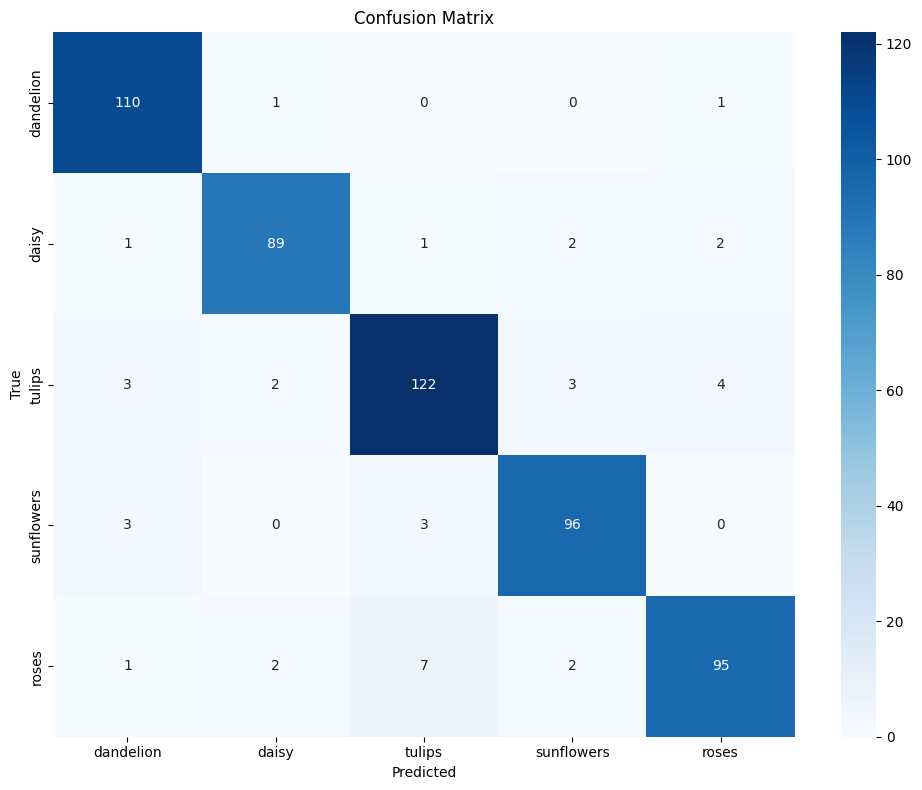

Saved TF SavedModel to: ./output_model/resnet_transfer_savedmodel.keras


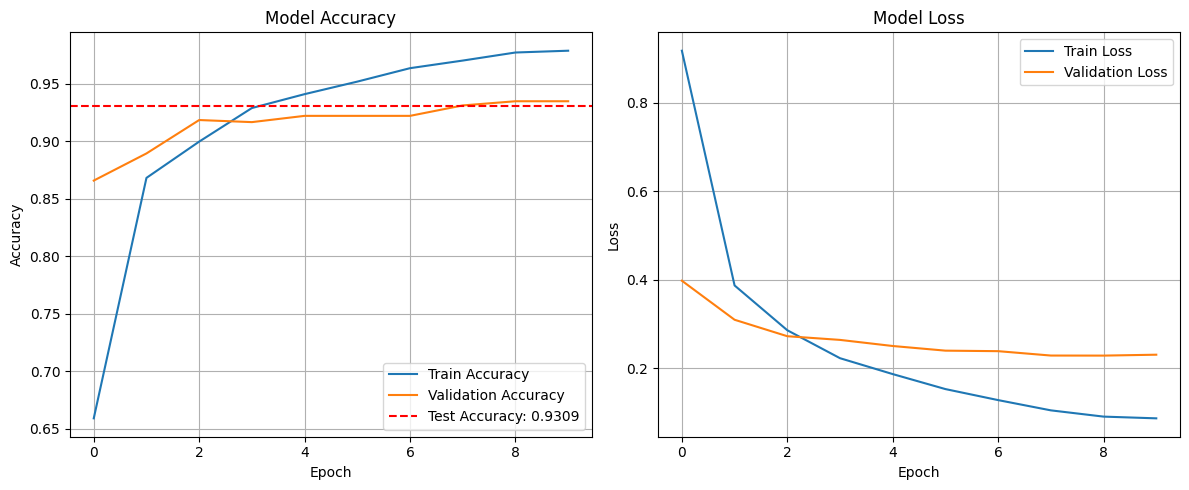


Evaluation on Test Set:
Test Accuracy: 0.9309


In [ ]:
# Train and evaluate the model using the function from resnet_transfer_train.py
# Use the original build_model function which expects categorical_crossentropy
# Train and evaluate the model using the function from resnet_transfer_train.py
# Use the original build_model function which expects categorical_crossentropy
model, history, (y_true, y_pred, y_prob), _ = train_and_evaluate(
    train_ds,
    val_ds,
    test_ds,
    class_names,
    args
)

# Access the training history from the model object
# The history is now directly returned by the function, no need to access it from model.history
# history = model.history

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# Add test accuracy as a horizontal line
test_acc = accuracy_score(y_true, y_pred)
plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# Note: Calculating test loss from the metrics might require re-evaluating the model or capturing it during evaluation
# For now, we'll focus on train/val loss and indicate where test loss would be if easily available.

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nEvaluation on Test Set:")
print(f"Test Accuracy: {test_acc:.4f}")

### **Task 6: Test the model on image.**
Using `predict_example()` to test on a `rose.jpg` image, to the seek the prediction.

In [ ]:
model_path = '/content/output_model/best_model.h5'
img_paths = ['/content/rose.jpg']
class_name = "rose"
predict_examples(model_path, img_paths, class_names, img_size=224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
File: /content/rose.jpg
 Predicted: roses (idx 4) - confidence 1.0000
 Top-3:
   roses: 1.0000
   tulips: 0.0000
   dandelion: 0.0000
---


## **Discussion**

This project successfully implemented a convolutional neural network for flower species classification using transfer learning with the ResNet50 architecture. By leveraging pre-trained weights from ImageNet, the model was able to achieve good performance on the `tf_flowers` dataset with a relatively small number of training epochs and without extensive data augmentation.

**Key Findings:**

*   **Effective Transfer Learning:** The high validation and test accuracies demonstrate the effectiveness of using a pre-trained ResNet50 as a feature extractor for this image classification task. Freezing the backbone during initial training allowed the model to quickly adapt to the new dataset by training only the newly added layers.
*   **Training Progress:** The training and validation accuracy curves show a consistent increase over epochs, while the loss curves decrease, indicating that the model is learning effectively. The close proximity of the training and validation curves suggests that overfitting is not a significant issue with the current hyperparameters and dataset split.
*   **Model Performance:** The model achieved a test accuracy of 0.9309, with comparable precision, recall, and F1-scores, indicating strong performance across the different flower classes.
*   **Confusion Matrix Analysis:** The confusion matrix provides a detailed breakdown of the model's predictions, showing which classes are most often confused with each other. This can be a valuable tool for identifying areas where the model could be improved, although in this case, the confusion matrix shows generally high accuracy for all classes.
*   **Prediction Example:** The successful prediction on the `rose.jpg` image further validates the model's ability to correctly classify unseen images.

**Potential Next Steps:**

*   **Hyperparameter Tuning:** Experiment with different hyperparameters, such as learning rate schedules, optimizer choices, or dropout rates, to potentially further improve performance.
*   **Data Augmentation:** Implement more aggressive data augmentation techniques to increase the diversity of the training data and potentially improve the model's generalization ability.
*   **Unfreezing and Fine-tuning:** After initial training with a frozen backbone, consider unfreezing some layers of the ResNet50 backbone and fine-tuning the entire model with a very low learning rate. This can allow the model to learn more task-specific features.
*   **Evaluate on a Larger/Different Dataset:** Test the model on a larger or more challenging flower dataset to assess its robustness and generalizability.
*   **Explore Other Architectures:** Experiment with other pre-trained convolutional neural network architectures to see if they yield better results.
*   **Deployment:** Once satisfied with the performance, consider deploying the trained model for real-world use cases, such as in a web application or mobile app.

## **Result and Conclusion:**<br>
In ten epochs the results are as follows:


1.   Training accuracy: 0.9775 , Training loss: 0.0892
2.   Validation accuracy: 0.9347, Validation loss:  0.2303
3.   Testing accuracy: 0.9309

We can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Good! Moreover, the validation curves are close to the training curves, which means that there is not too much overfitting. Therefore this model is best suited for predicting spieces of the flower.

